In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from dl_portfolio.backtest import sharpe_ratio, adjusted_sharpe_ratio, hist_VaR, hist_ES
import json

SAVE=True
save_dir = "prado/final/results_20230216_124856_targetvol_fin_leverage_max"
methods = ["HRP", "IVP", "NMF"]
if SAVE:
    if not os.path.isdir(f"{save_dir}/evaluation/"):
        os.mkdir(f"{save_dir}/evaluation/")
        
leverage = json.load(open(f"{save_dir}/leverage.json", "r"))

for m in methods:
    leverage[m] = np.array(leverage[m]).astype(float)

returns = {}
for m in methods:
    returns[m] = pd.read_csv(f"{save_dir}/returns_{m}.csv", index_col=0)
    returns[m] = returns[m].reset_index(drop=True)

for m in methods:
    returns[m] = returns[m].loc[:, ~returns["NMF"].isna().any()]

weights = {}
for m in methods:
    weights[m] = pd.read_csv(f"{save_dir}/weights_{m}.csv", index_col=0)
    
sr = pd.Series(dtype=np.float32)
for m in methods:
    sr[m] = returns[m].apply(sharpe_ratio, period=260, axis=0)
    
asr = pd.Series(dtype=np.float32)
for m in methods:
    asr[m] = returns[m].apply(adjusted_sharpe_ratio, axis=0)

vol = pd.Series(dtype=np.float32)
for m in methods:
    vol[m] = np.std(returns[m], axis=0) * np.sqrt(260)    
    
exp_ret = pd.Series(dtype=np.float32)
for m in methods:
    exp_ret[m] = np.mean(returns[m], axis=0)

VaR = pd.Series(dtype=np.float32)
for m in methods:
    VaR[m] = returns[m].apply(hist_VaR, level=0.05, axis=0)
    
ES = pd.Series(dtype=np.float32)
for m in methods:
    ES[m] = returns[m].apply(hist_ES, level=0.05, axis=0)
    
    
total_ret = pd.Series(dtype=np.float32)
for m in methods:
    total_ret[m] = np.cumprod(returns[m] + 1, axis=0).iloc[-1, :] - 1 
    
    
total_ret = pd.Series(dtype=np.float32)
for m in methods:
    total_ret[m] = np.cumprod(returns[m] + 1, axis=0).iloc[-1, :] - 1 

# Leverage

The plot below shows the distribution of the leverage factor for each strategy over all rebalancing periods of the various simulations. We observe that NMF needs much lower leverage to reach the 5% volatility target as it has more inherent volatility. On the other hand, HRP and IVP need more leverage since they have less volatility.

/Users/brunospilak/miniconda3/envs/embedding-portfolio/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


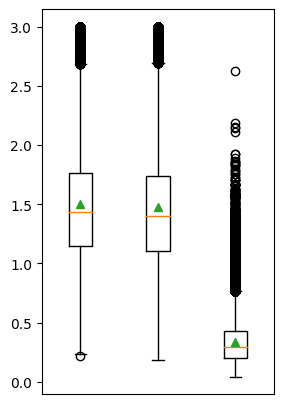

In [2]:
save=True
data = []
for i, m in enumerate(methods):
    temp = leverage[m].flatten()
    temp = temp[~np.isnan(temp)]
    data.append(temp)
plt.figure(figsize=(3,5))
_ = plt.boxplot(data, showmeans=True)
if not save:
    plt.title("Leverage")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/leverage.png", transparent=True, bbox_inches="tight")
plt.show()

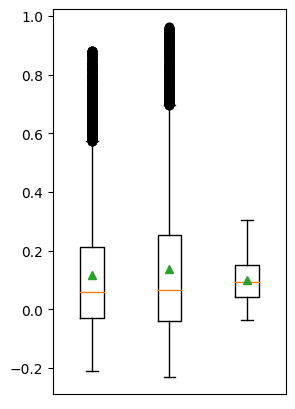

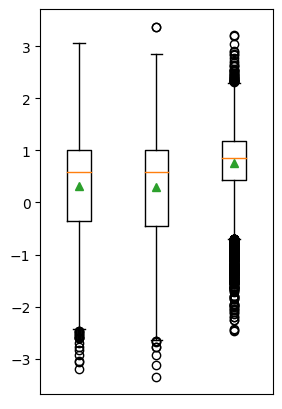

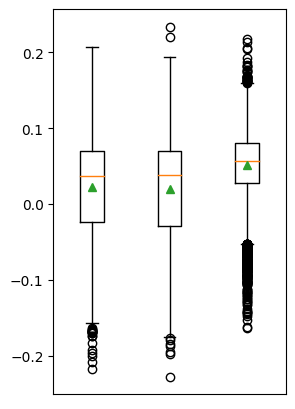

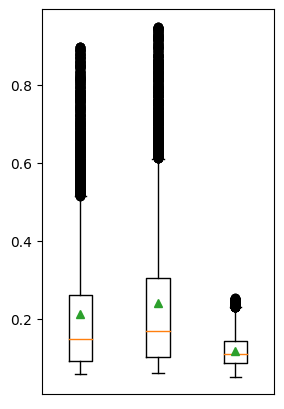

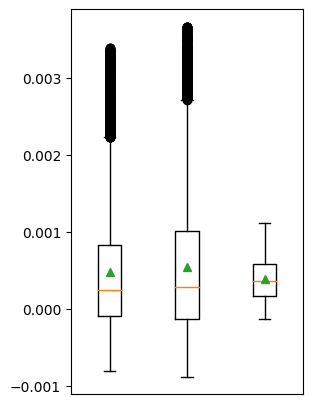

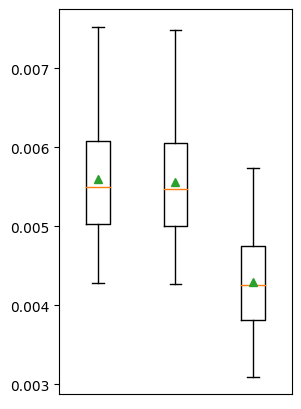

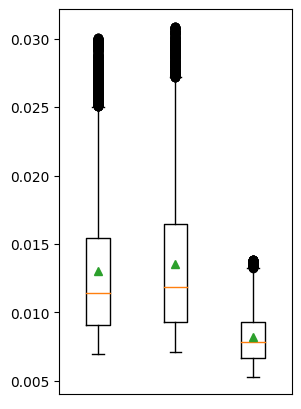

In [3]:
save=True

data = []
for i, m in enumerate(methods):
    temp = total_ret[m].values.copy()
    q1 = np.quantile(temp, 0.05)
    q3 = np.quantile(temp, 0.95)
    temp = temp[temp>=q1]
    temp = temp[temp<=q3]
    data.append(temp)
plt.figure(figsize=(3,5))
_ = plt.boxplot(data, showmeans=True)
if not save:
    plt.title("Total ret")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/total_ret.png", transparent=True, bbox_inches="tight")
plt.show()

data = []
for i, m in enumerate(methods):
    data.append(sr[m].values)
plt.figure(figsize=(3,5))
_ = plt.boxplot(data, showmeans=True)
if not save:
    plt.title("SR")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/sharpe_ratio.png", transparent=True, bbox_inches="tight")
plt.show()


data = []
for i, m in enumerate(methods):
    data.append(asr[m].values)
plt.figure(figsize=(3,5))
_ = plt.boxplot(data, showmeans=True)
if not save:
    plt.title("Adjusted SR")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/adj_sharpe_ratio.png", transparent=True, bbox_inches="tight")
plt.show()

data = []
for i, m in enumerate(methods):
    temp = vol[m].values.copy()
    q1 = np.quantile(temp, 0.05)
    q3 = np.quantile(temp, 0.95)
    temp = temp[temp>=q1]
    temp = temp[temp<=q3]
    data.append(temp)
plt.figure(figsize=(3,5))
_ = plt.boxplot(data, showmeans=True)
if not save:
    plt.title("Volatility")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/volatility.png", transparent=True, bbox_inches="tight")
plt.show()

data = []
for i, m in enumerate(methods):
    temp = exp_ret[m].values.copy()
    q1 = np.quantile(temp, 0.05)
    q3 = np.quantile(temp, 0.95)
    temp = temp[temp>=q1]
    temp = temp[temp<=q3]
    data.append(temp)
plt.figure(figsize=(3,5))
_ = plt.boxplot(data, showmeans=True)
if not save:
    plt.title("Returns")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/exp_returns.png", transparent=True, bbox_inches="tight")
plt.show()

data = []
for i, m in enumerate(methods):
    temp = VaR[m].values.copy()
    q1 = np.quantile(temp, 0.05)
    q3 = np.quantile(temp, 0.95)
    temp = temp[temp>=q1]
    temp = temp[temp<=q3]
    data.append(temp)
plt.figure(figsize=(3,5))
_ = plt.boxplot(data, showmeans=True)
if not save:
    plt.title("VaR 5%")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/var.png", transparent=True, bbox_inches="tight")
plt.show()

data = []
for i, m in enumerate(methods):
    temp = ES[m].values.copy()
    q1 = np.quantile(temp, 0.05)
    q3 = np.quantile(temp, 0.95)
    temp = temp[temp>=q1]
    temp = temp[temp<=q3]
    data.append(temp)
plt.figure(figsize=(3,5))
_ = plt.boxplot(data, showmeans=True)
if not save:
    plt.title("ES 5%")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/es.png", transparent=True, bbox_inches="tight")
plt.show()


In [4]:
n_assets = 20
ts_weights = {}
for m in methods:
    ts_weights[m] = weights[m].loc[:,~weights[m].isna().any()]
    ts_weights[m] = ts_weights[m].values.reshape(12, n_assets, ts_weights[m].values.shape[-1])

/Users/brunospilak/miniconda3/envs/embedding-portfolio/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


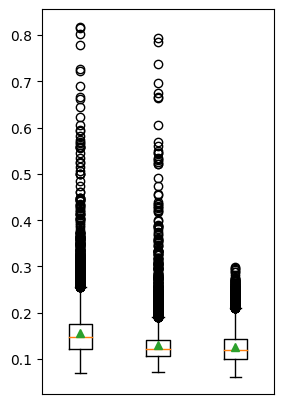

/Users/brunospilak/miniconda3/envs/embedding-portfolio/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


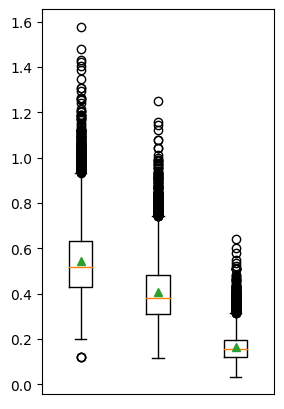

In [6]:
from dl_portfolio.backtest import sspw, total_average_turnover

save=True

sspw_res = []
for i, m in enumerate(methods):
    temp = np.array([sspw(ts_weights[m][:,:,i]) for i in range(ts_weights[m].shape[-1])])
    temp = temp[~np.isnan(temp)]
    sspw_res.append(temp)
plt.figure(figsize=(3,5))
_ = plt.boxplot(sspw_res, showmeans=True)
if not save:
    plt.title("SSPW")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/sspw.png", transparent=True, bbox_inches="tight")
plt.show()



tato_res = []
for i, m in enumerate(methods):
    temp = np.array(leverage[m]).T[:,np.newaxis,~weights[m].isna().any()] * ts_weights[m]
    temp = np.array([total_average_turnover(temp[:,:,i]) for i in range(temp.shape[-1])])
    temp = temp[~np.isnan(temp)]
    tato_res.append(temp)

plt.figure(figsize=(3,5))
_ = plt.boxplot(tato_res, showmeans=True)
if not save:
    plt.title("TATO")
    plt.xticks(range(1, 4), methods)
else:
    plt.xticks([])
if save:
    plt.savefig(f"{save_dir}/evaluation/tato.png", transparent=True, bbox_inches="tight")
plt.show()
